In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline
import os, sys, gc, warnings, random, datetime

/Users/shuozhang/anaconda/envs/py3k/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train=pd.read_csv('train_final4.csv')
test=pd.read_csv('test_final4.csv')

In [3]:
obj_cols = train.dtypes
obj_cols[obj_cols=='object']

DT                 object
addr1_card1        object
card2_and_count    object
dtype: object

In [4]:
train['card2_and_count']=pd.to_numeric(train['card2_and_count'],errors='coerce')
train['addr1_card1']=pd.to_numeric(train['addr1_card1'],errors='coerce')

In [5]:
test['card2_and_count']=pd.to_numeric(test['card2_and_count'],errors='coerce')
test['addr1_card1']=pd.to_numeric(test['addr1_card1'],errors='coerce')

In [6]:
split_groups = train['DT_M']

In [7]:
X= train.drop(['TransactionDT','TransactionID','uid','uid2','bank_type',
               'isFraud','DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month'], axis=1)
y = train['isFraud']

In [8]:
X.shape

(590540, 949)

In [9]:
X_test = test.drop(['TransactionDT','TransactionID','uid','uid2','bank_type',
                    'isFraud','DT','DT_M','DT_W','DT_D','DT_hour','DT_day_week','DT_day_month'], axis=1)

In [10]:
X_test.shape

(506691, 949)

In [11]:
del train, test
gc.collect()

7

In [12]:
from sklearn.model_selection import GroupKFold
NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)
splits = folds.split(X, y, groups=split_groups)

In [13]:
for fold_n, (train_index, valid_index) in enumerate(splits):
    train_index_df=pd.DataFrame(train_index,columns=['train_index'])
    valid_index_df=pd.DataFrame(valid_index,columns=['valid_index'])
    del train_index, valid_index
    gc.collect()

In [14]:
train_index_df.shape

(420864, 1)

In [15]:
valid_index_df.shape

(169676, 1)

In [16]:
from bayes_opt import BayesianOptimization

In [17]:
train_index=train_index_df['train_index']
valid_index=valid_index_df['valid_index']

In [18]:
X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

In [19]:
X_train.shape

(420864, 949)

In [20]:
X_valid.shape

(169676, 949)

In [21]:
y_train.shape

(420864,)

In [22]:
y_valid.shape

(169676,)

In [23]:
def LGB_bayesian(
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight,
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    y_oof = np.zeros(X_valid.shape[0])

    param = {
              'num_leaves': num_leaves, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'max_depth': max_depth,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'max_bin':255,
              'random_state': 47,
              'learning_rate': 0.005,
              'boosting_type': 'gbdt',
              'bagging_seed': 11,
              'tree_learner':'serial',
              'verbosity': -1,
              'metric':'auc'}    
    
    trn_data= lgb.Dataset(X_train, label=y_train)
    val_data= lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(param, trn_data,  num_boost_round=10000, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    
    y_oof = clf.predict(X_valid, num_iteration=clf.best_iteration)  
    
    score = roc_auc_score(y_valid, y_oof)

    return score

In [24]:
bounds_LGB = {
    'num_leaves': (400, 600), 
    'min_data_in_leaf': (50,150),
    'bagging_fraction' : (0.2,0.9),
    'feature_fraction' : (0.2,0.9),
    'min_child_weight': (0.01, 0.1),   
    'reg_alpha': (0.3, 1), 
    'reg_lambda': (0.3, 1),
    'max_depth':(-1,15),
}

In [25]:
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB)

In [26]:
print(LGB_BO.space.keys)

['bagging_fraction', 'feature_fraction', 'max_depth', 'min_child_weight', 'min_data_in_leaf', 'num_leaves', 'reg_alpha', 'reg_lambda']


In [27]:
init_points = 3
n_iter = 7

In [28]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.841783	valid_1's auc: 0.840504
[400]	training's auc: 0.855992	valid_1's auc: 0.852107
[600]	training's auc: 0.865845	valid_1's auc: 0.861359
[800]	training's auc: 0.871227	valid_1's auc: 0.866249
[1000]	training's auc: 0.875966	valid_1's auc: 0.870349
[1200]	training's auc: 0.879877	valid_1's auc: 0.873236
[1400]	training's auc: 0.883114	valid_1's auc: 0.875976
[1600]	training's auc: 0.885906	valid_1's auc: 0.878871
[1800]	training's auc: 0.888163	valid_1's auc: 0.880928
[2000]	training's auc: 0.890111	valid_1's auc: 0.882465
[2200]

[1000]	training's auc: 0.999353	valid_1's auc: 0.951526
[1200]	training's auc: 0.999803	valid_1's auc: 0.95249
[1400]	training's auc: 0.999943	valid_1's auc: 0.953092
[1600]	training's auc: 0.999985	valid_1's auc: 0.953415
[1800]	training's auc: 0.999996	valid_1's auc: 0.953624
[2000]	training's auc: 0.999999	valid_1's auc: 0.953703
[2200]	training's auc: 1	valid_1's auc: 0.953774
[2400]	training's auc: 1	valid_1's auc: 0.953772
[2600]	training's auc: 1	valid_1's auc: 0.953786
[2800]	training's auc: 1	valid_1's auc: 0.953749
Early stopping, best iteration is:
[2342]	training's auc: 1	valid_1's auc: 0.953814
|  4        |  0.9538   |  0.9      |  0.2      | -1.0      |  0.1      |  150.0    |  600.0    |  1.0      |  0.3      |
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.956608	valid_1's auc: 0.923588
[400]	training's auc: 0.975793	valid_1's auc: 0.935381
[600]	training's auc: 0.987179	valid_1's auc: 0.942708
[800]	training's auc: 0.992787	vali

In [64]:
params = {'num_leaves': int(LGB_BO.max['params']['num_leaves']),
          'min_child_weight': LGB_BO.max['params']['min_child_weight'],
          'feature_fraction': LGB_BO.max['params']['feature_fraction'],
          'bagging_fraction': LGB_BO.max['params']['bagging_fraction'],
          'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']),
          'objective': 'binary',
          'tree_learner':'serial',
          'max_depth': int(LGB_BO.max['params']['max_depth']),
          'max_bin':255,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': LGB_BO.max['params']['reg_alpha'],
          'reg_lambda':LGB_BO.max['params']['reg_lambda'],
          'random_state': 47,
         }

In [31]:
params # copy this one

{'bagging_fraction': 0.90000000000000002,
 'bagging_seed': 11,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.20000000000000001,
 'learning_rate': 0.005,
 'max_bin': 255,
 'max_depth': -1,
 'metric': 'auc',
 'min_child_weight': 0.099999999999590305,
 'min_data_in_leaf': 150,
 'num_leaves': 600,
 'objective': 'binary',
 'random_state': 47,
 'reg_alpha': 0.99999999999840239,
 'reg_lambda': 0.29999999999999999,
 'tree_learner': 'serial',
 'verbosity': -1}

In [32]:
NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)

In [33]:
columns = X.columns
splits = folds.split(X, y, groups=split_groups)
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.974051	valid_1's auc: 0.888681
[400]	training's auc: 0.986416	valid_1's auc: 0.898135
[600]	training's auc: 0.993758	valid_1's auc: 0.903492
[800]	training's auc: 0.997481	valid_1's auc: 0.906653
[1000]	training's auc: 0.999061	valid_1's auc: 0.908632
[1200]	training's auc: 0.999676	valid_1's auc: 0.909919
[1400]	training's auc: 0.999892	valid_1's auc: 0.911227
[1600]	training's auc: 0.999966	valid_1's auc: 0.91207
[1800]	training's auc: 0.99999	valid_1's auc: 0.912568
[2000]	training's auc: 0.999997	valid_1's auc: 0.913036
[2200]	training's auc: 0.999999	valid_1's auc: 0.913366
[2400]	training's auc: 1	valid_1's auc: 0.913729
[2600]	training's auc: 1	valid_1's auc: 0.913961
[2800]	training's auc: 1	valid_1's auc: 0.914134
[3000]	training's auc: 1	valid_1's auc: 0.914304
[3200]	training's auc: 1	valid_1's auc: 0.914354
[3400]	training's auc: 1	valid_1's auc: 0.914436
[3600]	training's auc: 1	valid_1'

In [34]:
sub = pd.read_csv('sample_submission.csv')
sub['isFraud'] = y_preds
sub.to_csv("lgb_final4_bayes_or.csv", index=False)  #0.9498

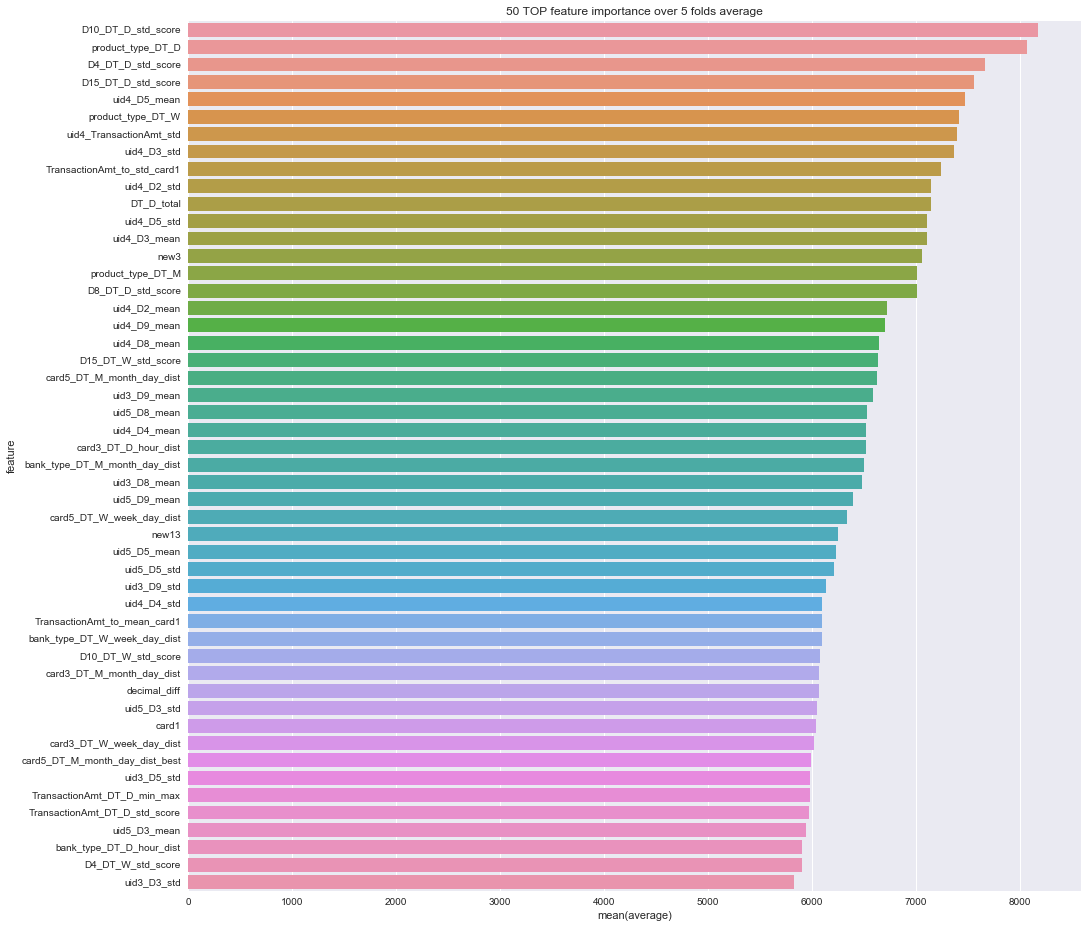

In [35]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

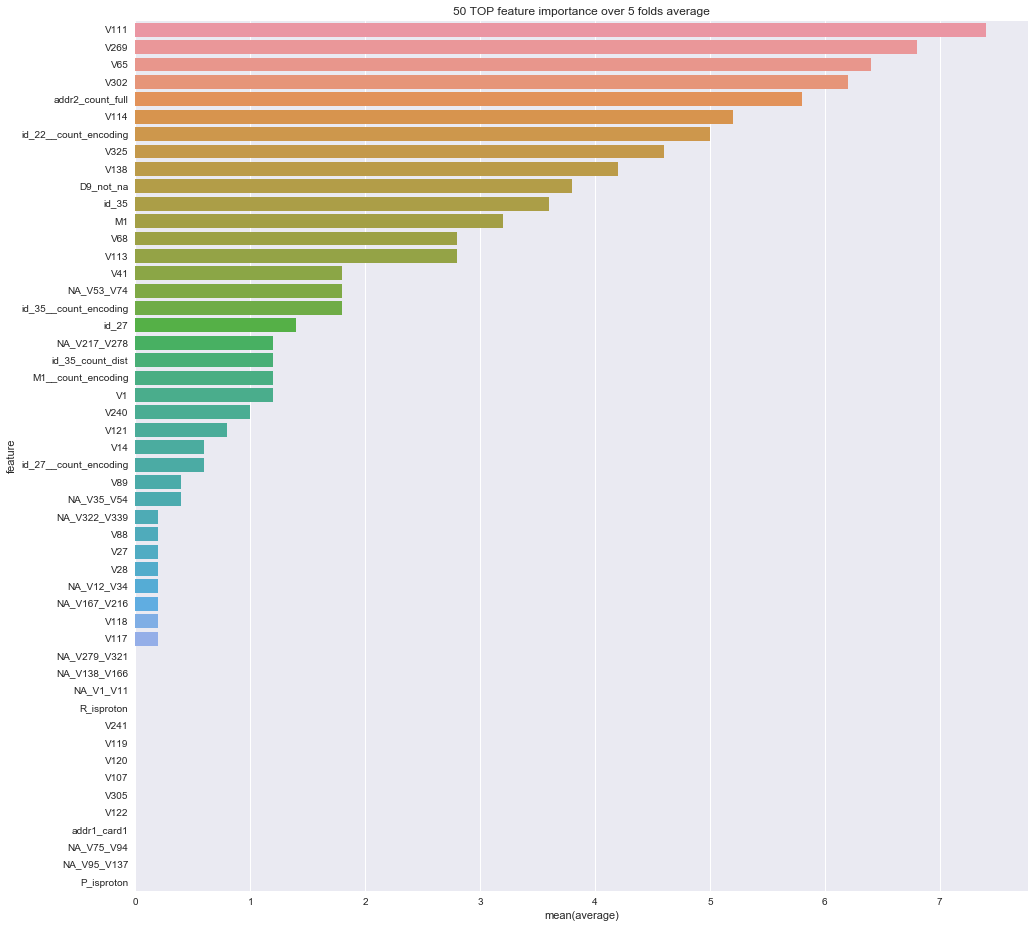

In [36]:
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).tail(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [37]:
data=feature_importances.sort_values(by='average', ascending=False).tail(14) #根据结果设置
data

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,average
814,NA_V279_V321,0,0,0,0,0,0.0
810,NA_V138_V166,0,0,0,0,0,0.0
812,NA_V1_V11,0,0,0,0,0,0.0
833,R_isproton,0,0,0,0,0,0.0
292,V241,0,0,0,0,0,0.0
170,V119,0,0,0,0,0,0.0
171,V120,0,0,0,0,0,0.0
158,V107,0,0,0,0,0,0.0
356,V305,0,0,0,0,0,0.0
173,V122,0,0,0,0,0,0.0


In [38]:
no_contribution_feature=data['feature']

In [39]:
no_contribution_feature # copy this 

814    NA_V279_V321
810    NA_V138_V166
812       NA_V1_V11
833      R_isproton
292            V241
170            V119
171            V120
158            V107
356            V305
173            V122
849     addr1_card1
818      NA_V75_V94
819     NA_V95_V137
826      P_isproton
Name: feature, dtype: object

In [40]:
X2=X.drop(no_contribution_feature, axis=1)

In [41]:
X_test2=X_test.drop(no_contribution_feature, axis=1)

In [42]:
X2.shape

(590540, 935)

In [43]:
X_test2.shape

(506691, 935)

In [44]:
del X, X_test
gc.collect()

42800

In [ ]:
params={'bagging_fraction': 0.90000000000000002,
        'bagging_seed': 11,
        'boosting_type': 'gbdt',
        'feature_fraction': 0.20000000000000001,
        'learning_rate': 0.005,
        'max_bin': 255,
        'max_depth': -1,
        'metric': 'auc',
        'min_child_weight': 0.099999999999590305,
        'min_data_in_leaf': 150,
        'num_leaves': 600,
        'objective': 'binary',
        'random_state': 47,
        'reg_alpha': 0.99999999999840239,
        'reg_lambda': 0.29999999999999999,
        'tree_learner': 'serial',
        'verbosity': -1} # copy this one

In [45]:
from sklearn.model_selection import GroupKFold
NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)

In [46]:
columns = X2.columns
splits = folds.split(X2, y, groups=split_groups)
y_preds = np.zeros(X_test2.shape[0])
y_oof = np.zeros(X2.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X2[columns].iloc[train_index], X2[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test2) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.973927	valid_1's auc: 0.88977
[400]	training's auc: 0.986311	valid_1's auc: 0.898199
[600]	training's auc: 0.993838	valid_1's auc: 0.904151
[800]	training's auc: 0.997485	valid_1's auc: 0.907265
[1000]	training's auc: 0.999069	valid_1's auc: 0.908819
[1200]	training's auc: 0.999681	valid_1's auc: 0.9104
[1400]	training's auc: 0.999894	valid_1's auc: 0.91125
[1600]	training's auc: 0.999967	valid_1's auc: 0.912013
[1800]	training's auc: 0.99999	valid_1's auc: 0.912381
[2000]	training's auc: 0.999997	valid_1's auc: 0.913008
[2200]	training's auc: 0.999999	valid_1's auc: 0.913152
[2400]	training's auc: 1	valid_1's auc: 0.913451
[2600]	training's auc: 1	valid_1's auc: 0.913634
[2800]	training's auc: 1	valid_1's auc: 0.913786
[3000]	training's auc: 1	valid_1's auc: 0.913947
[3200]	training's auc: 1	valid_1's auc: 0.914036
[3400]	training's auc: 1	valid_1's auc: 0.914023
[3600]	training's auc: 1	valid_1's a

In [47]:
sub = pd.read_csv('sample_submission.csv')
sub['isFraud'] = y_preds
sub.to_csv("lgb_final4_bayes_orre.csv", index=False) #0.9501

In [65]:
# change to 6 fold
params={'bagging_fraction': 0.90000000000000002,
        'bagging_seed': 11,
        'boosting_type': 'gbdt',
        'feature_fraction': 0.20000000000000001,
        'learning_rate': 0.005,
        'max_bin': 255,
        'max_depth': -1,
        'metric': 'auc',
        'min_child_weight': 0.099999999999590305,
        'min_data_in_leaf': 150,
        'num_leaves': 600,
        'objective': 'binary',
        'random_state': 47,
        'reg_alpha': 0.99999999999840239,
        'reg_lambda': 0.29999999999999999,
        'tree_learner': 'serial',
        'verbosity': -1}

In [68]:
from sklearn.model_selection import GroupKFold
NFOLDS = 6
folds = GroupKFold(n_splits=NFOLDS)

In [69]:
columns = X2.columns
splits = folds.split(X2, y, groups=split_groups)
y_preds = np.zeros(X_test2.shape[0])
y_oof = np.zeros(X2.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X2[columns].iloc[train_index], X2[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test2) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.973927	valid_1's auc: 0.889767
[400]	training's auc: 0.986311	valid_1's auc: 0.898196
[600]	training's auc: 0.993838	valid_1's auc: 0.904151
[800]	training's auc: 0.997485	valid_1's auc: 0.907258
[1000]	training's auc: 0.999069	valid_1's auc: 0.908813
[1200]	training's auc: 0.999681	valid_1's auc: 0.910396
[1400]	training's auc: 0.999894	valid_1's auc: 0.911247
[1600]	training's auc: 0.999967	valid_1's auc: 0.91201
[1800]	training's auc: 0.99999	valid_1's auc: 0.912379
[2000]	training's auc: 0.999997	valid_1's auc: 0.913007
[2200]	training's auc: 0.999999	valid_1's auc: 0.913151
[2400]	training's auc: 1	valid_1's auc: 0.91345
[2600]	training's auc: 1	valid_1's auc: 0.913633
[2800]	training's auc: 1	valid_1's auc: 0.913786
[3000]	training's auc: 1	valid_1's auc: 0.913947
[3200]	training's auc: 1	valid_1's auc: 0.914035
[3400]	training's auc: 1	valid_1's auc: 0.914022
[3600]	training's auc: 1	valid_1's

In [70]:
sub = pd.read_csv('sample_submission.csv')
sub['isFraud'] = y_preds
sub.to_csv("lgb_final4_fold6_orre.csv", index=False) #0.9501, no improvement

In [48]:
X_train, X_valid = X2.iloc[train_index], X2.iloc[valid_index]
y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

In [49]:
X_train.shape

(420864, 935)

In [50]:
X_valid.shape

(169676, 935)

In [51]:
y_train.shape

(420864,)

In [52]:
y_valid.shape

(169676,)

In [53]:
def LGB_bayesian(
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight,
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    y_oof = np.zeros(X_valid.shape[0])

    param = {
              'num_leaves': num_leaves, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'max_depth': max_depth,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'max_bin':255,
              'random_state': 47,
              'learning_rate': 0.005,
              'boosting_type': 'gbdt',
              'bagging_seed': 11,
              'tree_learner':'serial',
              'verbosity': -1,
              'metric':'auc'}    
    
    trn_data= lgb.Dataset(X_train, label=y_train)
    val_data= lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(param, trn_data,  num_boost_round=10000, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    
    y_oof = clf.predict(X_valid, num_iteration=clf.best_iteration)  
    
    score = roc_auc_score(y_valid, y_oof)

    return score

In [54]:
bounds_LGB = {
    'num_leaves': (400, 600), 
    'min_data_in_leaf': (50,150),
    'bagging_fraction' : (0.2,0.9),
    'feature_fraction' : (0.2,0.9),
    'min_child_weight': (0.01, 0.1),   
    'reg_alpha': (0.3, 1), 
    'reg_lambda': (0.3, 1),
    'max_depth':(-1,15),
}

In [55]:
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB)

In [56]:
print(LGB_BO.space.keys)

['bagging_fraction', 'feature_fraction', 'max_depth', 'min_child_weight', 'min_data_in_leaf', 'num_leaves', 'reg_alpha', 'reg_lambda']


In [57]:
init_points = 3 #5
n_iter = 7 # 15

In [58]:
print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | max_depth | min_ch... | min_da... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.881226	valid_1's auc: 0.872898
[400]	training's auc: 0.901193	valid_1's auc: 0.888433
[600]	training's auc: 0.91094	valid_1's auc: 0.896862
[800]	training's auc: 0.917952	valid_1's auc: 0.902207
[1000]	training's auc: 0.923581	valid_1's auc: 0.905958
[1200]	training's auc: 0.927623	valid_1's auc: 0.908573
[1400]	training's auc: 0.93106	valid_1's auc: 0.911082
[1600]	training's auc: 0.934101	valid_1's auc: 0.913155
[1800]	training's auc: 0.936969	valid_1's auc: 0.914967
[2000]	training's auc: 0.939223	valid_1's auc: 0.916479
[2200]	t

[5400]	training's auc: 0.979672	valid_1's auc: 0.936678
[5600]	training's auc: 0.980638	valid_1's auc: 0.937156
[5800]	training's auc: 0.981509	valid_1's auc: 0.937502
[6000]	training's auc: 0.982394	valid_1's auc: 0.937878
[6200]	training's auc: 0.983202	valid_1's auc: 0.938176
[6400]	training's auc: 0.98401	valid_1's auc: 0.938491
[6600]	training's auc: 0.984796	valid_1's auc: 0.938774
[6800]	training's auc: 0.985469	valid_1's auc: 0.938961
[7000]	training's auc: 0.986133	valid_1's auc: 0.939228
[7200]	training's auc: 0.986819	valid_1's auc: 0.939499
[7400]	training's auc: 0.98745	valid_1's auc: 0.93971
[7600]	training's auc: 0.988039	valid_1's auc: 0.939912
[7800]	training's auc: 0.988642	valid_1's auc: 0.940158
[8000]	training's auc: 0.989197	valid_1's auc: 0.940412
[8200]	training's auc: 0.989717	valid_1's auc: 0.940614
[8400]	training's auc: 0.990223	valid_1's auc: 0.940852
[8600]	training's auc: 0.990746	valid_1's auc: 0.941127
[8800]	training's auc: 0.991245	valid_1's auc: 0.94

[1000]	training's auc: 0.999848	valid_1's auc: 0.951871
[1200]	training's auc: 0.999975	valid_1's auc: 0.952824
[1400]	training's auc: 0.999997	valid_1's auc: 0.953379
[1600]	training's auc: 1	valid_1's auc: 0.953704
[1800]	training's auc: 1	valid_1's auc: 0.953871
[2000]	training's auc: 1	valid_1's auc: 0.954017
[2200]	training's auc: 1	valid_1's auc: 0.954071
[2400]	training's auc: 1	valid_1's auc: 0.954131
Early stopping, best iteration is:
[2080]	training's auc: 1	valid_1's auc: 0.954016
|  10       |  0.954    |  0.5962   |  0.7728   | -0.421    |  0.0221   |  149.2    |  599.8    |  0.3133   |  0.3557   |


In [59]:
params = {'num_leaves': int(LGB_BO.max['params']['num_leaves']),
          'min_child_weight': LGB_BO.max['params']['min_child_weight'],
          'feature_fraction': LGB_BO.max['params']['feature_fraction'],
          'bagging_fraction': LGB_BO.max['params']['bagging_fraction'],
          'min_data_in_leaf': int(LGB_BO.max['params']['min_data_in_leaf']),
          'objective': 'binary',
          'tree_learner':'serial',
          'max_depth': int(LGB_BO.max['params']['max_depth']),
          'max_bin':255,
          'learning_rate': 0.005,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': LGB_BO.max['params']['reg_alpha'],
          'reg_lambda':LGB_BO.max['params']['reg_lambda'],
          'random_state': 47,
         }

In [60]:
params

{'bagging_fraction': 0.59617831293224077,
 'bagging_seed': 11,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.77283633330978452,
 'learning_rate': 0.005,
 'max_bin': 255,
 'max_depth': 0,
 'metric': 'auc',
 'min_child_weight': 0.022103749828015013,
 'min_data_in_leaf': 149,
 'num_leaves': 599,
 'objective': 'binary',
 'random_state': 47,
 'reg_alpha': 0.31331177511237596,
 'reg_lambda': 0.35567469305452731,
 'tree_learner': 'serial',
 'verbosity': -1}

In [61]:
NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)

In [62]:
columns = X2.columns
splits = folds.split(X2, y, groups=split_groups)
y_preds = np.zeros(X_test2.shape[0])
y_oof = np.zeros(X2.shape[0])
score = 0

feature_importances = pd.DataFrame()
feature_importances['feature'] = columns
  
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X2[columns].iloc[train_index], X2[columns].iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)

    clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
    
    y_pred_valid = clf.predict(X_valid)
    y_oof[valid_index] = y_pred_valid
    print(f"Fold {fold_n + 1} | AUC: {roc_auc_score(y_valid, y_pred_valid)}")
    
    score += roc_auc_score(y_valid, y_pred_valid) / NFOLDS
    y_preds += clf.predict(X_test2) / NFOLDS
    
    del X_train, X_valid, y_train, y_valid
    gc.collect()
    
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y, y_oof)}")

Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.978102	valid_1's auc: 0.887863
[400]	training's auc: 0.989816	valid_1's auc: 0.897632
[600]	training's auc: 0.996358	valid_1's auc: 0.902244
[800]	training's auc: 0.998935	valid_1's auc: 0.905716
[1000]	training's auc: 0.999743	valid_1's auc: 0.90784
[1200]	training's auc: 0.999946	valid_1's auc: 0.909489
[1400]	training's auc: 0.999991	valid_1's auc: 0.910539
[1600]	training's auc: 0.999999	valid_1's auc: 0.911416
[1800]	training's auc: 1	valid_1's auc: 0.912351
[2000]	training's auc: 1	valid_1's auc: 0.912961
[2200]	training's auc: 1	valid_1's auc: 0.913491
[2400]	training's auc: 1	valid_1's auc: 0.913842
[2600]	training's auc: 1	valid_1's auc: 0.91402
Early stopping, best iteration is:
[2155]	training's auc: 1	valid_1's auc: 0.913451
Fold 1 | AUC: 0.9134236362099156
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.976597	valid_1's auc: 0.923708
[400]	training'

In [63]:
sub = pd.read_csv('sample_submission.csv')
sub['isFraud'] = y_preds
sub.to_csv("lgb_final4_bayes_orre2.csv", index=False) #0.9490